Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам. 

Подключим необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

Настроим pandas и зугрузим наш датасет.

In [2]:
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

math = pd.read_csv('data/stud_math.csv')

Опишем вспомогательные функции, которые пригодятся в будущем.

In [3]:
def describe_numeric(df, hist=False):
    print(df.describe())
    if(hist):
        df.hist()
    nan_count = len(math) - df.count()
    if nan_count > 0:
        print('\nЗаписи без данных графе "{}": {}'.format(df.name, nan_count))
        print('\nНеинформативные для критерия "{}" записи:'.format(df.name))
        display(math.loc[math[df.name].isnull()])
    else:
        print('\nНеинформативные для критерия "{}" записи отсутствуют.'.format(df.name))

Самым важным полем для анализа явдяется поле score. Записи, в которых отсутсвуют данные по рейтинг учащегося неинформатиный для нас и будут лишь загрязнять основную выборку. Избавимся от них на начально этапе.

In [4]:
describe_numeric(math.score)

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Записи без данных графе "score": 6

Неинформативные для критерия "score" записи:


school sex  age address famsize Pstatus  Medu  Fedu   Mjob      Fjob  \
201     GP   F   16       U     GT3       T   2.0   3.0  other     other   
244     GP   F   18       U     GT3       T   2.0   1.0  other     other   
270     GP   F   19     NaN     GT3       T   3.0   3.0  other  services   
283     GP   F   18       U     GT3       T   1.0   1.0  other     other   
312     GP   M   19       U     GT3       T   1.0   2.0  other  services   
350     MS   M   19     NaN     GT3       T   1.0   1.0  other  services   

         reason guardian  traveltime  studytime  failures schoolsup famsup  \
201  reputation   mother         1.0        2.0       0.0       yes    yes   
244      course    other         2.0        3.0       0.0        no    yes   
270        home    other         1.0        2.0       2.0        no    yes   
283        home   mother         2.0        2.0       0.0       yes    NaN   
312      course    other         1.0        2.0       1.0        no     no   
350        home    other         3.0        2.0       3.0        no     no   

    paid activities nursery  studytime, granular higher internet romantic  \
201  NaN        yes     yes                 -6.0    yes       no       no   
244  yes         no      no                 -9.0    yes      yes      yes   
270  yes        yes     yes                 -6.0    yes      yes       no   
283   no        yes     yes                 -6.0    yes      yes       no   
312   no         no      no                 -6.0    yes      yes       no   
350   no         no     NaN                 -6.0    yes      yes       no   

     famrel  freetime  goout  health  absences  score  
201     4.0       NaN    3.0     4.0       6.0    NaN  
244     4.0       4.0    4.0     3.0       0.0    NaN  
270     4.0       3.0    5.0     5.0       NaN    NaN  
283     5.0       NaN    4.0     4.0       4.0    NaN  
312     4.0       5.0    NaN     4.0       3.0    NaN  
350     5.0       4.0    4.0     2.0       8.0    NaN

In [5]:
math = math.dropna(subset=['score'])
describe_numeric(math.score)

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Неинформативные для критерия "score" записи отсутствуют.


Нормализуем названия колонок и сделаем их более более информативными.

In [6]:
display(math.columns)
math.columns = ['school', 'sex', 'age', 'address', 'family_size', 'parents_status', 'mother_education', 'father_education',
        'mother_job', 'father_job', 'school_selection_reason', 'guardian', 'travel_time', 'study_time', 'failures',
        'school_support', 'family_support', 'paid', 'activities', 'nursery', 'study_time_granular', 'higher', 'internet',
        'romantic', 'family_relations', 'free_time', 'go_out', 'health', 'absences', 'score']
display(math.columns)

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

Index(['school', 'sex', 'age', 'address', 'family_size', 'parents_status',
       'mother_education', 'father_education', 'mother_job', 'father_job',
       'school_selection_reason', 'guardian', 'travel_time', 'study_time',
       'failures', 'school_support', 'family_support', 'paid', 'activities',
       'nursery', 'study_time_granular', 'higher', 'internet', 'romantic',
       'family_relations', 'free_time', 'go_out', 'health', 'absences',
       'score'],
      dtype='object')

## Первичный анализ данных в столбцах

## Описание датасета
Посмотрим на переменные, которые содержит датасет:

1 school — аббревиатура школы, в которой учится ученик

2 sex — пол ученика ('F' - женский, 'M' - мужской)

3 age — возраст ученика (от 15 до 22)

4 address — тип адреса ученика ('U' - городской, 'R' - за городом)

5 family_size — размер семьи('LE3' <= 3, 'GT3' >3)

6 parents_status — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

7 mother_education — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

8 father_education — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

9 mother_job — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

10 father_job — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

11 school_selection_reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

13 travel_time — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

14 study_time — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

15 failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

16 school_support — дополнительная образовательная поддержка (yes или no)

17 family_support — семейная образовательная поддержка (yes или no)

18 paid — дополнительные платные занятия по математике (yes или no)

19 activities — дополнительные внеучебные занятия (yes или no)

20 nursery — посещал детский сад (yes или no)

21 higher — хочет получить высшее образование (yes или no)

22 internet — наличие интернета дома (yes или no)

23 romantic — в романтических отношениях (yes или no)

24 family_relations — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

25 free_time — свободное время после школы (от 1 - очень мало до 5 - очень мого)

26 go_out — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

28 absences — количество пропущенных занятий

29 score — баллы по госэкзамену по математике



In [7]:
math.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   school                   389 non-null    object 
 1   sex                      389 non-null    object 
 2   age                      389 non-null    int64  
 3   address                  374 non-null    object 
 4   family_size              362 non-null    object 
 5   parents_status           344 non-null    object 
 6   mother_education         386 non-null    float64
 7   father_education         365 non-null    float64
 8   mother_job               370 non-null    object 
 9   father_job               353 non-null    object 
 10  school_selection_reason  372 non-null    object 
 11  guardian                 358 non-null    object 
 12  travel_time              361 non-null    float64
 13  study_time               382 non-null    float64
 14  failures                 3

Разделим столбцы на дву группы:
* числовые переменные
* номинативные переменные

In [8]:
nominative = math.select_dtypes(include='object')
print('Номинативные признаки:\n', nominative.columns)

Номинативные признаки:
 Index(['school', 'sex', 'address', 'family_size', 'parents_status',
       'mother_job', 'father_job', 'school_selection_reason', 'guardian',
       'school_support', 'family_support', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic'],
      dtype='object')


### Первичный анализ данных в столбцах: числовые признакки

In [9]:
numeric = math.select_dtypes(include=['int64', 'float64'])
print('Числовые признаки:\n', numeric.columns)

Числовые признаки:
 Index(['age', 'mother_education', 'father_education', 'travel_time',
       'study_time', 'failures', 'study_time_granular', 'family_relations',
       'free_time', 'go_out', 'health', 'absences', 'score'],
      dtype='object')


Рассмотрим числовые признаки по одному.

#### age
возраст ученика (от 15 до 22)

In [10]:
describe_numeric(math.age)

count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

Неинформативные для критерия "age" записи отсутствуют.


Пропущеных значейний и выбросов в данном столбце не наблюдаем. Все данные находятся в описаном в задаче промежутке от 15 до 22 лет.

#### mother_education
образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [11]:
describe_numeric(math.mother_education)

count    386.000000
mean       2.766839
std        1.094277
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: mother_education, dtype: float64

Записи без данных графе "mother_education": 3

Неинформативные для критерия "mother_education" записи:


school sex  age address family_size parents_status  mother_education  \
92      GP   F   16     NaN         LE3              T               NaN   
193     GP   M   16       R         GT3            NaN               NaN   
239     GP   M   18       U         GT3            NaN               NaN   

     father_education mother_job father_job school_selection_reason guardian  \
92                1.0      other      other                    home   father   
193               3.0   services   services              reputation   mother   
239               2.0      other   services              reputation   father   

     travel_time  study_time  failures school_support family_support paid  \
92           1.0         2.0       0.0            yes            yes   no   
193          1.0         1.0       0.0             no            yes   no   
239          1.0         2.0       1.0             no             no   no   

    activities nursery  study_time_granular higher internet romantic  \
92          no     yes                 -6.0    yes       no       no   
193        yes     yes                 -3.0    yes      yes       no   
239         no     yes                 -6.0     no      NaN      NaN   

     family_relations  free_time  go_out  health  absences  score  
92                3.0        3.0     NaN     2.0       4.0   30.0  
193               4.0        3.0     2.0     5.0       8.0   50.0  
239               5.0        5.0     4.0     2.0       0.0    0.0

В столбце есть 3 пропуска, заполнить их мы не можем.
Остальные данные лежат в промежутке указанном в условии задачи. 
По данным можно сказать что большая часть матерей имеет как минимум среднее образование.

### father_education
образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [12]:
describe_numeric(math.father_education)

count    365.000000
mean       2.627397
std        2.241790
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       40.000000
Name: father_education, dtype: float64

Записи без данных графе "father_education": 24

Неинформативные для критерия "father_education" записи:


school sex  age address family_size parents_status  mother_education  \
21      GP   M   15       U         GT3              T               4.0   
42      GP   M   15       U         GT3              T               4.0   
46      GP   F   16       U         LE3              A               3.0   
57      GP   M   15       U         GT3              T               4.0   
58      GP   M   15       U         LE3              T               1.0   
67      GP   F   16       U         GT3            NaN               3.0   
137     GP   F   16       U         GT3              A               3.0   
142     GP   F   15       U         GT3              T               4.0   
159     GP   M   16     NaN         GT3              T               3.0   
161     GP   M   15       R         GT3              T               3.0   
180     GP   M   16       U         GT3              T               4.0   
195     GP   F   17       U         NaN              T               2.0   
232     GP   M   17       U         GT3              T               4.0   
236     GP   M   17       U         LE3              T               2.0   
259     GP   F   17       U         LE3              T               2.0   
280     GP   M   17       U         NaN              A               4.0   
281     GP   M   17       U         LE3              A               3.0   
286     GP   F   18       U         GT3              T               2.0   
287     GP   F   17       U         GT3              T               1.0   
290     GP   M   18       U         GT3              T               4.0   
310     GP   F   19       U         LE3              T               1.0   
328     GP   F   17       U         GT3              T               4.0   
349     MS   M   18       R         GT3              T               3.0   
374     MS   F   18       R         LE3              T               4.0   

     father_education mother_job father_job school_selection_reason guardian  \
21                NaN     health     health                   other   father   
42                NaN   services    teacher                  course   father   
46                NaN      other   services                    home   mother   
57                NaN    teacher     health              reputation   mother   
58                NaN      other    at_home                    home   father   
67                NaN   services      other                  course   mother   
137               NaN      other      other                     NaN    other   
142               NaN    teacher   services                  course   mother   
159               NaN      other   services                  course   father   
161               NaN      other        NaN                  course   mother   
180               NaN    teacher      other                    home   mother   
195               NaN   services   services                  course   father   
232               NaN    teacher    teacher              reputation   mother   
236               NaN      other      other                    home   father   
259               NaN   services   services                  course   father   
280               NaN   services      other                    home   mother   
281               NaN    teacher   services                    home   mother   
286               NaN    at_home    at_home                   other   mother   
287               NaN   services    teacher              reputation   mother   
290               NaN    teacher      other                    home   mother   
310               NaN   services   services                    home    other   
328               NaN    teacher   services                  course   mother   
349               NaN      other      other                  course      NaN   
374               NaN      other        NaN              reputation   mother   

     travel_time  study_time  failures school_support family_support paid  \
21           1.0         

В столбце есть пропуски, заполнить их мы не можем.
На графике четко виден выброс со значение 40, избавимся от него.

In [13]:
math = math.loc[math.father_education != 40]
describe_numeric(math.father_education)

count    364.000000
mean       2.524725
std        1.086833
min        0.000000
25%        2.000000
50%        2.500000
75%        3.000000
max        4.000000
Name: father_education, dtype: float64

Записи без данных графе "father_education": 24

Неинформативные для критерия "father_education" записи:


school sex  age address family_size parents_status  mother_education  \
21      GP   M   15       U         GT3              T               4.0   
42      GP   M   15       U         GT3              T               4.0   
46      GP   F   16       U         LE3              A               3.0   
57      GP   M   15       U         GT3              T               4.0   
58      GP   M   15       U         LE3              T               1.0   
67      GP   F   16       U         GT3            NaN               3.0   
137     GP   F   16       U         GT3              A               3.0   
142     GP   F   15       U         GT3              T               4.0   
159     GP   M   16     NaN         GT3              T               3.0   
161     GP   M   15       R         GT3              T               3.0   
180     GP   M   16       U         GT3              T               4.0   
195     GP   F   17       U         NaN              T               2.0   
232     GP   M   17       U         GT3              T               4.0   
236     GP   M   17       U         LE3              T               2.0   
259     GP   F   17       U         LE3              T               2.0   
280     GP   M   17       U         NaN              A               4.0   
281     GP   M   17       U         LE3              A               3.0   
286     GP   F   18       U         GT3              T               2.0   
287     GP   F   17       U         GT3              T               1.0   
290     GP   M   18       U         GT3              T               4.0   
310     GP   F   19       U         LE3              T               1.0   
328     GP   F   17       U         GT3              T               4.0   
349     MS   M   18       R         GT3              T               3.0   
374     MS   F   18       R         LE3              T               4.0   

     father_education mother_job father_job school_selection_reason guardian  \
21                NaN     health     health                   other   father   
42                NaN   services    teacher                  course   father   
46                NaN      other   services                    home   mother   
57                NaN    teacher     health              reputation   mother   
58                NaN      other    at_home                    home   father   
67                NaN   services      other                  course   mother   
137               NaN      other      other                     NaN    other   
142               NaN    teacher   services                  course   mother   
159               NaN      other   services                  course   father   
161               NaN      other        NaN                  course   mother   
180               NaN    teacher      other                    home   mother   
195               NaN   services   services                  course   father   
232               NaN    teacher    teacher              reputation   mother   
236               NaN      other      other                    home   father   
259               NaN   services   services                  course   father   
280               NaN   services      other                    home   mother   
281               NaN    teacher   services                    home   mother   
286               NaN    at_home    at_home                   other   mother   
287               NaN   services    teacher              reputation   mother   
290               NaN    teacher      other                    home   mother   
310               NaN   services   services                    home    other   
328               NaN    teacher   services                  course   mother   
349               NaN      other      other                  course      NaN   
374               NaN      other        NaN              reputation   mother   

     travel_time  study_time  failures school_support family_support paid  \
21           1.0         

По данным можно сказать что большая часть отцов имеет как минимум среднее образование.

### travel_time
время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

In [14]:
describe_numeric(math.travel_time)

count    360.000000
mean       1.430556
std        0.688675
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: travel_time, dtype: float64

Записи без данных графе "travel_time": 28

Неинформативные для критерия "travel_time" записи:


school sex  age address family_size parents_status  mother_education  \
26      GP   M   15       U         GT3              T               2.0   
30      GP   M   15       U         GT3              T               4.0   
35      GP   F   15       U         GT3              T               2.0   
37      GP   M   16       R         GT3              A               4.0   
59      GP   F   16       U         GT3              T               4.0   
68      GP   F   15       R         LE3              T               2.0   
70      GP   M   16       U         GT3              T               3.0   
104     GP   M   15       U         GT3              A               3.0   
112     GP   F   16       U         GT3            NaN               2.0   
132     GP   F   17       U         LE3              T               2.0   
134     GP   M   15       R         GT3              T               3.0   
137     GP   F   16       U         GT3              A               3.0   
142     GP   F   15       U         GT3              T               4.0   
147     GP   F   15       U         GT3            NaN               1.0   
157     GP   F   18       R         GT3              T               1.0   
160     GP   M   17       R         LE3              T               2.0   
182     GP   F   17       U         GT3            NaN               2.0   
226     GP   F   17       U         GT3              T               3.0   
234     GP   M   16       U         LE3            NaN               1.0   
241     GP   M   17     NaN         LE3              A               4.0   
261     GP   M   18       U         GT3              T               4.0   
268     GP   M   18       U         NaN            NaN               4.0   
310     GP   F   19       U         LE3              T               1.0   
348     GP   F   17     NaN         GT3              T               4.0   
372     MS   F   17     NaN         GT3              T               2.0   
384     MS   M   18       R         GT3              T               4.0   
385     MS   F   18       R         GT3              T               2.0   
389     MS   F   18       U         GT3              T               1.0   

     father_education mother_job father_job school_selection_reason guardian  \
26                2.0      other        NaN                    home   mother   
30                4.0     health   services                    home   mother   
35                3.0      other      other                   other   father   
37                4.0      other    teacher              reputation   mother   
59                2.0        NaN        NaN                  course   mother   
68                2.0     health        NaN              reputation   mother   
70                1.0      other      other              reputation   father   
104               4.0        NaN      other                  course   mother   
112               2.0    at_home      other                     NaN   mother   
132               2.0      other      other                  course   father   
134               4.0    at_home    teacher                  course   mother   
137               NaN      other      other                     NaN    other   
142               NaN    teacher   services                  course   mother   
147               2.0    at_home      other                  course   mother   
157               1.0    at_home      other                  course   mother   
160               1.0    at_home        NaN                  course   mother   
182               4.0   services        NaN              reputation   father   
226               2.0      other      other                  course   mother   
234               1.0      other      other                    home   mother   
241               4.0    teacher      other                  course   mother   
261               3.0    teacher      other                  course   mother   
268               2.0        NaN      o

В данных есть пропуски, заполнить их нет возможности.
Судя по остальным данным большинство учащихся тратят на дорогу не больше 15 минут.

### study_time
 время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

In [15]:
describe_numeric(math.study_time)
math.study_time.value_counts()

count    381.000000
mean       2.034121
std        0.846908
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: study_time, dtype: float64

Записи без данных графе "study_time": 7

Неинформативные для критерия "study_time" записи:


school sex  age address family_size parents_status  mother_education  \
17      GP   F   16       U         GT3              T               3.0   
91      GP   F   15       U         GT3              T               4.0   
112     GP   F   16       U         GT3            NaN               2.0   
129     GP   M   16       R         NaN              T               4.0   
227     GP   M   17       U         LE3            NaN               2.0   
266     GP   M   17       U         GT3            NaN               3.0   
314     GP   F   19       U         GT3              T               1.0   

     father_education mother_job father_job school_selection_reason guardian  \
17                3.0      other        NaN              reputation   mother   
91                3.0   services      other              reputation   mother   
112               2.0    at_home      other                     NaN   mother   
129               4.0    teacher    teacher                  course   mother   
227               3.0   services   services              reputation   father   
266               1.0   services        NaN                   other   mother   
314               1.0    at_home     health                    home    other   

     travel_time  study_time  failures school_support family_support paid  \
17           3.0         NaN       0.0            yes            NaN   no   
91           1.0         NaN       NaN             no             no  yes   
112          NaN         NaN       1.0            yes             no   no   
129          1.0         NaN       0.0             no             no  yes   
227          1.0         NaN       0.0             no            yes  yes   
266          1.0         NaN       0.0             no             no  yes   
314          1.0         NaN       2.0             no             no   no   

    activities nursery  study_time_granular higher internet romantic  \
17         yes     yes                  NaN    yes       no       no   
91         yes     yes                  NaN    yes      yes       no   
112        yes     yes                  NaN    yes      yes      NaN   
129        yes     yes                  NaN    yes      yes       no   
227         no      no                  NaN    NaN      yes       no   
266        yes     yes                  NaN    yes      yes      NaN   
314         no      no                  NaN    yes      yes      yes   

     family_relations  free_time  go_out  health  absences  score  
17                5.0        3.0     2.0     4.0       4.0   50.0  
91                4.0        5.0     5.0     1.0       4.0   90.0  
112               3.0        1.0     2.0     5.0       6.0   65.0  
129               3.0        5.0     5.0     4.0       NaN   90.0  
227               5.0        3.0     3.0     3.0       NaN   60.0  
266               5.0        4.0     4.0     NaN       2.0   50.0  
314               4.0        NaN     2.0     3.0      14.0   65.0

2.0    189
1.0    103
3.0     62
4.0     27
Name: study_time, dtype: int64

В столбце есть пропуски, по остальным данным видно, что большиство обучающихся тратит на учебу помимо школы еще от 2 до 5ти часов.

### study_time_granular
в описании задачи данный столбец отсутствует, из названия можно предположить что эта информация связана со столбцом study_time. Проверим кореллируют ли они.

In [16]:
corr = math.study_time_granular.corr(math.study_time)
print('Значение корелляции:', corr)

Значение корелляции: -0.999999999999999


Как видно из значения, study_time_granular и study_time имеют оюратную кореляцию. В чем можно убедиться на графике.

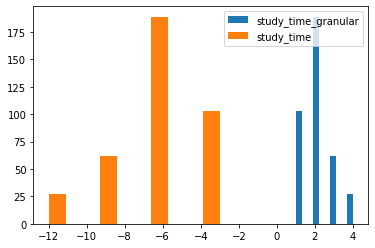

In [17]:
plt.hist(math.study_time, label='study_time_granular')
plt.hist(math.study_time_granular, label='study_time')
plt.legend(loc='bottom')
plt.show()

Так, как новых полезных данных информация в столбце study_time_granular нам не дает, избавимся от него.

In [18]:
math.drop(['study_time_granular'], inplace = True, axis = 1)
display(math.head(5))
math.info()

school sex  age address family_size parents_status  mother_education  \
0     GP   F   18       U         NaN              A               4.0   
1     GP   F   17       U         GT3            NaN               1.0   
2     GP   F   15       U         LE3              T               1.0   
3     GP   F   15       U         GT3              T               4.0   
4     GP   F   16       U         GT3              T               3.0   

   father_education mother_job father_job school_selection_reason guardian  \
0               4.0    at_home    teacher                  course   mother   
1               1.0    at_home      other                  course   father   
2               1.0    at_home      other                   other   mother   
3               2.0     health        NaN                    home   mother   
4               3.0      other      other                    home   father   

   travel_time  study_time  failures school_support family_support paid  \
0          2.0         2.0       0.0            yes             no   no   
1          1.0         2.0       0.0             no            yes   no   
2          1.0         2.0       3.0            yes             no  NaN   
3          1.0         3.0       0.0             no            yes  yes   
4          1.0         2.0       0.0             no            yes  yes   

  activities nursery higher internet romantic  family_relations  free_time  \
0         no     yes    yes      NaN       no               4.0        3.0   
1         no      no    yes      yes       no               5.0        3.0   
2         no     yes    yes      yes      NaN               4.0        3.0   
3        yes     yes    yes      yes      yes               3.0        2.0   
4         no     yes    yes       no       no               4.0        3.0   

   go_out  health  absences  score  
0     4.0     3.0       6.0   30.0  
1     3.0     3.0       4.0   30.0  
2     2.0     3.0      10.0   50.0  
3     2.0     5.0       2.0   75.0  
4     2.0     5.0       4.0   50.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 394
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   school                   388 non-null    object 
 1   sex                      388 non-null    object 
 2   age                      388 non-null    int64  
 3   address                  373 non-null    object 
 4   family_size              361 non-null    object 
 5   parents_status           344 non-null    object 
 6   mother_education         385 non-null    float64
 7   father_education         364 non-null    float64
 8   mother_job               369 non-null    object 
 9   father_job               352 non-null    object 
 10  school_selection_reason  371 non-null    object 
 11  guardian                 357 non-null    object 
 12  travel_time              360 non-null    float64
 13  study_time               381 non-null    float64
 14  failures                 3

### failures
failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)


In [19]:
describe_numeric(math.failures)

count    366.000000
mean       0.327869
std        0.730276
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

Записи без данных графе "failures": 22

Неинформативные для критерия "failures" записи:


school sex  age address family_size parents_status  mother_education  \
21      GP   M   15       U         GT3              T               4.0   
48      GP   M   15       U         GT3              T               4.0   
54      GP   F   15       U         LE3            NaN               3.0   
68      GP   F   15       R         LE3              T               2.0   
91      GP   F   15       U         GT3              T               4.0   
107     GP   M   16       U         GT3              T               3.0   
108     GP   M   15       R         GT3            NaN               4.0   
114     GP   M   15       R         NaN              T               2.0   
115     GP   M   16       U         GT3              T               4.0   
125     GP   M   15       U         GT3              T               3.0   
153     GP   M   19       U         GT3            NaN               3.0   
158     GP   M   16       R         GT3            NaN               2.0   
170     GP   M   16       U         GT3              T               3.0   
171     GP   M   16       U         GT3              T               1.0   
204     GP   F   16       R         GT3              T               2.0   
214     GP   F   17       R         LE3              T               4.0   
236     GP   M   17       U         LE3              T               2.0   
261     GP   M   18       U         GT3              T               4.0   
280     GP   M   17       U         NaN              A               4.0   
313     GP   F   19       U         NaN            NaN               3.0   
320     GP   F   17       U         GT3              A               4.0   
344     GP   F   18       U         NaN              T               2.0   

     father_education mother_job father_job school_selection_reason guardian  \
21                NaN     health     health                   other   father   
48                2.0    teacher      other                    home   mother   
54                3.0        NaN      other                   other   mother   
68                2.0     health        NaN              reputation   mother   
91                3.0   services      other              reputation   mother   
107               3.0   services        NaN                    home   father   
108               4.0      other      other                    home   father   
114               1.0     health   services              reputation   mother   
115               4.0    teacher    teacher                  course   father   
125               4.0   services   services                    home   father   
153               2.0   services    at_home                    home   mother   
158               2.0    at_home      other                  course   mother   
170               4.0      other      other                  course   father   
171               0.0      other      other              reputation   mother   
204               2.0   services   services              reputation   mother   
214               4.0   services      other                   other   mother   
236               NaN      other      other                    home   father   
261               3.0    teacher      other                  course   mother   
280               NaN   services      other                    home   mother   
313               2.0   services      other              reputation    other   
320               3.0   services   services                  course   mother   
344               3.0    at_home      other                  course      NaN   

     travel_time  study_time  failures school_support family_support paid  \
21           1.0         1.0       NaN             no            yes  NaN   
48           1.0         2.0       NaN             no            yes  yes   
54           1.0         1.0       NaN             no             no  yes   
68           NaN         2.0       NaN            yes            yes  NaN   
91           1.0         NaN 

В столбце имеются пропуски. Остальные данные указывают на то, что подавляющее большинство учащихся не имеют внеучебных неудач (что под ними не имелось в виду), а у остальных их не больше 3.

### family_relations
семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

In [20]:
describe_numeric(math.family_relations)

count    361.000000
mean       3.927978
std        0.931139
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: family_relations, dtype: float64

Записи без данных графе "family_relations": 27

Неинформативные для критерия "family_relations" записи:


school sex  age address family_size parents_status  mother_education  \
8       GP   M   15       U         LE3              A               3.0   
12      GP   M   15       U         LE3              T               4.0   
20      GP   M   15       U         GT3              T               4.0   
43      GP   M   15       U         GT3              T               2.0   
72      GP   F   15       R         GT3              T               1.0   
73      GP   M   16       U         GT3              T               3.0   
75      GP   M   15     NaN         GT3              T               4.0   
94      GP   M   15       U         LE3              T               2.0   
102     GP   M   15       U         GT3              T               4.0   
118     GP   M   17       R         GT3              T               1.0   
136     GP   M   17       R         GT3              T               3.0   
160     GP   M   17       R         LE3              T               2.0   
195     GP   F   17       U         NaN              T               2.0   
217     GP   M   18       U         LE3              T               3.0   
229     GP   F   17       U         GT3              A               2.0   
276     GP   F   18       R         GT3              A               3.0   
290     GP   M   18       U         GT3              T               4.0   
309     GP   F   19       U         LE3              T               1.0   
317     GP   F   18       U         GT3              T               4.0   
323     GP   F   17       U         GT3              T               3.0   
337     GP   F   17       U         GT3              T               3.0   
347     GP   M   18       U         GT3              T               4.0   
348     GP   F   17     NaN         GT3              T               4.0   
349     MS   M   18       R         GT3              T               3.0   
355     MS   F   18       U         GT3              T               3.0   
360     MS   F   18       R         NaN              A               1.0   
373     MS   F   17       R         GT3              T               1.0   

     father_education mother_job father_job school_selection_reason guardian  \
8                 2.0   services      other                    home   mother   
12                4.0     health   services                  course   father   
20                3.0    teacher      other              reputation   mother   
43                2.0   services   services                  course   father   
72                1.0      other      other              reputation   mother   
73                1.0      other      other                     NaN   mother   
75                3.0    teacher      other                    home   mother   
94                2.0   services     health              reputation   mother   
102               4.0   services      other                  course   mother   
118               3.0      other        NaN                  course   father   
136               4.0    at_home      other                  course   mother   
160               1.0    at_home        NaN                  course   mother   
195               NaN   services   services                  course   father   
217               3.0   services     health                    home   father   
229               1.0      other        NaN                  course   mother   
276               2.0      other   services                    home   mother   
290               NaN    teacher      other                    home   mother   
309               1.0    at_home        NaN              reputation    other   
317               3.0      other      other                  course   mother   
323               1.0   services   services                  course   father   
337               2.0        NaN      other                    home   mother   
347               3.0    teacher      other                  course      NaN   
348               3.0     health   

В столбце есть пропуски, заполнить их мы не можем.
На графике четко виден выброс со значение -1, избавимся от него.

In [21]:
math = math.loc[math.family_relations != -1]
describe_numeric(math.family_relations)


count    360.000000
mean       3.941667
std        0.895322
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: family_relations, dtype: float64

Записи без данных графе "family_relations": 27

Неинформативные для критерия "family_relations" записи:


school sex  age address family_size parents_status  mother_education  \
8       GP   M   15       U         LE3              A               3.0   
12      GP   M   15       U         LE3              T               4.0   
20      GP   M   15       U         GT3              T               4.0   
43      GP   M   15       U         GT3              T               2.0   
72      GP   F   15       R         GT3              T               1.0   
73      GP   M   16       U         GT3              T               3.0   
75      GP   M   15     NaN         GT3              T               4.0   
94      GP   M   15       U         LE3              T               2.0   
102     GP   M   15       U         GT3              T               4.0   
118     GP   M   17       R         GT3              T               1.0   
136     GP   M   17       R         GT3              T               3.0   
160     GP   M   17       R         LE3              T               2.0   
195     GP   F   17       U         NaN              T               2.0   
217     GP   M   18       U         LE3              T               3.0   
229     GP   F   17       U         GT3              A               2.0   
276     GP   F   18       R         GT3              A               3.0   
290     GP   M   18       U         GT3              T               4.0   
309     GP   F   19       U         LE3              T               1.0   
317     GP   F   18       U         GT3              T               4.0   
323     GP   F   17       U         GT3              T               3.0   
337     GP   F   17       U         GT3              T               3.0   
347     GP   M   18       U         GT3              T               4.0   
348     GP   F   17     NaN         GT3              T               4.0   
349     MS   M   18       R         GT3              T               3.0   
355     MS   F   18       U         GT3              T               3.0   
360     MS   F   18       R         NaN              A               1.0   
373     MS   F   17       R         GT3              T               1.0   

     father_education mother_job father_job school_selection_reason guardian  \
8                 2.0   services      other                    home   mother   
12                4.0     health   services                  course   father   
20                3.0    teacher      other              reputation   mother   
43                2.0   services   services                  course   father   
72                1.0      other      other              reputation   mother   
73                1.0      other      other                     NaN   mother   
75                3.0    teacher      other                    home   mother   
94                2.0   services     health              reputation   mother   
102               4.0   services      other                  course   mother   
118               3.0      other        NaN                  course   father   
136               4.0    at_home      other                  course   mother   
160               1.0    at_home        NaN                  course   mother   
195               NaN   services   services                  course   father   
217               3.0   services     health                    home   father   
229               1.0      other        NaN                  course   mother   
276               2.0      other   services                    home   mother   
290               NaN    teacher      other                    home   mother   
309               1.0    at_home        NaN              reputation    other   
317               3.0      other      other                  course   mother   
323               1.0   services   services                  course   father   
337               2.0        NaN      other                    home   mother   
347               3.0    teacher      other                  course      NaN   
348               3.0     health   

Судя по оставшимся данным, большиство учащихся оченивают отношения в семье достаточно хорошо.

### free_time
свободное время после школы (от 1 - очень мало до 5 - очень мого)

In [22]:
describe_numeric(math.free_time)

count    378.000000
mean       3.230159
std        0.991979
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: free_time, dtype: float64

Записи без данных графе "free_time": 9

Неинформативные для критерия "free_time" записи:


school sex  age address family_size parents_status  mother_education  \
32      GP   M   15       R         NaN              T               4.0   
74      GP   F   16       U         GT3              T               3.0   
131     GP   F   15       U         GT3            NaN               1.0   
280     GP   M   17       U         NaN              A               4.0   
290     GP   M   18       U         GT3              T               4.0   
291     GP   F   17       U         GT3              T               4.0   
311     GP   F   19       U         GT3              T               2.0   
314     GP   F   19       U         GT3              T               1.0   
338     GP   F   18       U         LE3              T               3.0   

     father_education mother_job father_job school_selection_reason guardian  \
32                3.0    teacher    at_home                  course   mother   
74                3.0      other   services                    home   mother   
131               1.0    at_home      other                  course   mother   
280               NaN   services      other                    home   mother   
290               NaN    teacher      other                    home   mother   
291               3.0        NaN   services              reputation      NaN   
311               1.0    at_home      other                   other    other   
314               1.0    at_home     health                    home    other   
338               3.0   services   services                    home   mother   

     travel_time  study_time  failures school_support family_support paid  \
32           1.0         2.0       0.0             no            yes   no   
74           1.0         2.0       0.0            yes            yes  yes   
131          3.0         1.0       0.0             no            yes   no   
280          2.0         1.0       NaN             no             no  yes   
290          1.0         2.0       0.0             no            yes  yes   
291          1.0         3.0       0.0             no            yes  yes   
311          3.0         2.0       0.0             no            yes   no   
314          1.0         NaN       2.0             no             no   no   
338          1.0         4.0       0.0             no            yes   no   

    activities nursery higher internet romantic  family_relations  free_time  \
32         yes     NaN    yes      yes      yes               4.0        NaN   
74         yes     yes    yes      yes       no               4.0        NaN   
131        yes      no    yes      yes      yes               4.0        NaN   
280        yes     yes    yes      yes      NaN               4.0        NaN   
290        yes     yes    yes      yes      NaN               NaN        NaN   
291         no     yes    yes      yes       no               4.0        NaN   
311         no     yes     no      yes      yes               3.0        NaN   
314         no      no    yes      yes      yes               4.0        NaN   
338         no     yes    yes      yes       no               5.0        NaN   

     go_out  health  absences  score  
32      2.0     5.0       0.0   80.0  
74      3.0     5.0      54.0   55.0  
131     3.0     4.0       0.0    0.0  
280     4.0     5.0      30.0   40.0  
290     2.0     5.0      11.0   55.0  
291     2.0     3.0       0.0   75.0  
311     1.0     2.0      20.0   65.0  
314     2.0     3.0      14.0   65.0  
338     3.0     1.0       7.0   85.0

В столбце присутствуют пропуски, заполнить их мы не можем. По данным можно прийти к выводу, что у большинства учащихся остается достаточно свободного времени.

### go_out
проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

In [23]:
describe_numeric(math.go_out)

count    380.000000
mean       3.100000
std        1.116204
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: go_out, dtype: float64

Записи без данных графе "go_out": 7

Неинформативные для критерия "go_out" записи:


school sex  age address family_size parents_status  mother_education  \
89      GP   M   16       U         LE3              A               4.0   
92      GP   F   16     NaN         LE3              T               NaN   
200     GP   F   16       U         GT3              T               4.0   
202     GP   F   17       U         NaN              T               1.0   
221     GP   F   17       U         NaN              T               1.0   
241     GP   M   17     NaN         LE3              A               4.0   
322     GP   F   17       R         LE3              T               2.0   

     father_education mother_job father_job school_selection_reason guardian  \
89                4.0    teacher     health              reputation   mother   
92                1.0      other      other                    home   father   
200               3.0     health      other                    home   mother   
202               1.0      other      other                  course   mother   
221               1.0    at_home      other              reputation   mother   
241               4.0    teacher      other                  course   mother   
322               2.0   services   services                  course   mother   

     travel_time  study_time  failures school_support family_support paid  \
89           1.0         2.0       0.0             no            yes   no   
92           1.0         2.0       0.0            yes            yes   no   
200          1.0         2.0       0.0             no            yes  NaN   
202          1.0         2.0       0.0             no            yes  yes   
221          1.0         3.0       1.0             no            yes   no   
241          NaN         2.0       0.0             no            yes  yes   
322          1.0         3.0       0.0             no            yes  yes   

    activities nursery higher internet romantic  family_relations  free_time  \
89          no     yes    yes       no       no               4.0        1.0   
92          no     yes    yes       no       no               3.0        3.0   
200        yes     yes    yes      yes       no               4.0        3.0   
202         no      no    yes       no       no               4.0        4.0   
221        yes     yes    yes       no      yes               4.0        3.0   
241         no     yes    yes      yes       no               3.0        3.0   
322        yes     yes    yes      yes       no               3.0        3.0   

     go_out  health  absences  score  
89      NaN     5.0      18.0   35.0  
92      NaN     2.0       4.0   30.0  
200     NaN     2.0       2.0   80.0  
202     NaN     1.0       4.0   50.0  
221     NaN     5.0       0.0    0.0  
241     NaN     4.0       2.0   60.0  
322     NaN     3.0       3.0   55.0

В столбце присутствуют пропуски, заполнить их мы не можем. По данным можно сделать вывод, что большинство учащихся проводят достаточно много времени с друзьями.

### health
текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

In [24]:
describe_numeric(math.health)

count    372.000000
mean       3.524194
std        1.403483
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

Записи без данных графе "health": 15

Неинформативные для критерия "health" записи:


school sex  age address family_size parents_status  mother_education  \
30      GP   M   15       U         GT3              T               4.0   
55      GP   F   16       U         GT3              A               2.0   
88      GP   M   16       U         GT3              T               2.0   
145     GP   F   15       U         GT3              T               1.0   
153     GP   M   19       U         GT3            NaN               3.0   
164     GP   M   17       R         LE3              T               1.0   
189     GP   M   17       R         GT3              T               1.0   
208     GP   F   16       U         GT3              T               1.0   
220     GP   F   17       R         GT3              T               2.0   
236     GP   M   17       U         LE3              T               2.0   
256     GP   F   17       U         LE3              T               4.0   
259     GP   F   17       U         LE3              T               2.0   
266     GP   M   17       U         GT3            NaN               3.0   
330     GP   M   18       U         LE3              T               2.0   
342     GP   M   18       U         LE3            NaN               3.0   

     father_education mother_job father_job school_selection_reason guardian  \
30                4.0     health   services                    home   mother   
55                1.0      other      other                   other   mother   
88                2.0        NaN      other              reputation   father   
145               1.0        NaN   services                  course   father   
153               2.0   services    at_home                    home   mother   
164               1.0      other   services                  course      NaN   
189               2.0    at_home      other                    home   mother   
208               1.0    at_home      other                    home   mother   
220               1.0    at_home   services              reputation   mother   
236               NaN      other      other                    home   father   
256               2.0    teacher   services              reputation   mother   
259               NaN   services   services                  course   father   
266               1.0   services        NaN                   other   mother   
330               2.0      other      other                  course   mother   
342               4.0   services      other                    home   mother   

     travel_time  study_time  failures school_support family_support paid  \
30           NaN         2.0       0.0             no            yes  yes   
55           1.0         2.0       0.0             no             no  yes   
88           2.0         2.0       1.0             no             no  yes   
145          1.0         2.0       0.0             no            yes  yes   
153          1.0         1.0       NaN             no            yes   no   
164          4.0         2.0       3.0             no             no  NaN   
189          1.0         2.0       0.0             no             no   no   
208          2.0         1.0       0.0             no            yes  yes   
220          2.0         2.0       0.0             no            yes   no   
236          1.0         2.0       NaN             no             no  NaN   
256          1.0         4.0       0.0             no            yes  NaN   
259          1.0         4.0       0.0             no             no  yes   
266          1.0         NaN       0.0             no             no  yes   
330          1.0         4.0       0.0             no            yes   no   
342          1.0         2.0       0.0             no             no   no   

    activities nursery higher internet romantic  family_relations  free_time  \
30          no      no    yes      yes       no               5.0        4.0   
55         yes     yes    yes      yes      yes               5.0        3.0   
88         yes     NaN    yes    

В столбце присутствуют пропуски, заполнить их мы не можем. Можно сделать заключение, что большинство учащихся чувствуют себя хорошо.

### absences
количество пропущенных занятий

In [25]:
describe_numeric(math.absences)
math.absences.value_counts().sort_index()

count    376.000000
mean       7.311170
std       23.675281
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

Записи без данных графе "absences": 11

Неинформативные для критерия "absences" записи:


school sex  age address family_size parents_status  mother_education  \
24      GP   F   15       R         GT3              T               2.0   
101     GP   M   16       U         GT3              T               4.0   
120     GP   F   15       U         GT3              T               1.0   
129     GP   M   16       R         NaN              T               4.0   
150     GP   M   18       U         LE3              T               1.0   
172     GP   M   17       U         NaN              T               4.0   
215     GP   F   17       U         LE3              T               3.0   
227     GP   M   17       U         LE3            NaN               2.0   
254     GP   M   17     NaN         NaN              T               2.0   
265     GP   M   18       R         LE3            NaN               3.0   
352     MS   M   18       U         LE3              T               1.0   

     father_education mother_job father_job school_selection_reason guardian  \
24                4.0   services     health                  course   mother   
101               4.0   services    teacher                   other   father   
120               2.0    at_home        NaN                  course   mother   
129               4.0    teacher    teacher                  course   mother   
150               1.0      other      other                  course   mother   
172               4.0    teacher      other              reputation   mother   
215               2.0      other      other              reputation   mother   
227               3.0   services   services              reputation   father   
254               1.0      other      other                  course   mother   
265               4.0        NaN      other              reputation   mother   
352               3.0    at_home   services                  course   mother   

     travel_time  study_time  failures school_support family_support paid  \
24           1.0         3.0       0.0            yes            yes  yes   
101          1.0         3.0       0.0             no            yes   no   
120          1.0         2.0       0.0             no             no   no   
129          1.0         NaN       0.0             no             no  yes   
150          1.0         1.0       3.0             no             no   no   
172          1.0         2.0       0.0             no            yes  yes   
215          2.0         2.0       0.0             no             no  NaN   
227          1.0         NaN       0.0             no            yes  yes   
254          1.0         1.0       0.0             no             no   no   
265          2.0         2.0       0.0             no            yes  yes   
352          1.0         1.0       1.0             no             no   no   

    activities nursery higher internet romantic  family_relations  free_time  \
24         yes     yes    yes      yes       no               4.0        3.0   
101        yes     yes    yes      yes      yes               4.0        4.0   
120         no      no    yes      yes       no               3.0        2.0   
129        yes     yes    yes      yes       no               3.0        5.0   
150         no     yes     no      yes      yes               2.0        3.0   
172        yes     yes    yes      yes       no               4.0        4.0   
215         no     yes    yes      NaN       no               4.0        4.0   
227         no      no    NaN      yes       no               5.0        3.0   
254         no      no    yes      yes       no               4.0        4.0   
265        yes     yes    yes      yes       no               4.0        2.0   
352         no     yes     no      yes      yes               4.0        3.0   

     go_out  health  absences  score  
24      2.0     5.0       NaN   40.0  
101     3.0     4.0       NaN   85.0  
120     3.0     1.0       NaN   75.0  
129     5.0     4.0       NaN   90.0  
150     5.0     4.0       NaN    0.0  
172     4.

0.0      110
1.0        3
2.0       60
3.0        7
4.0       51
5.0        5
6.0       30
7.0        6
8.0       20
9.0        3
10.0      17
11.0       2
12.0      12
13.0       2
14.0      11
15.0       2
16.0       7
17.0       1
18.0       5
19.0       1
20.0       4
21.0       1
22.0       3
23.0       1
24.0       1
25.0       1
26.0       1
28.0       1
30.0       1
38.0       1
40.0       1
54.0       1
56.0       1
75.0       1
212.0      1
385.0      1
Name: absences, dtype: int64

In [26]:
# math = math.loc[(math.absences != 212) & (math.absences != 385)]
# TODO
math = math.loc[math.absences < 30]
describe_numeric(math.absences)

count    368.000000
mean       5.051630
std        5.744804
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max       28.000000
Name: absences, dtype: float64

Неинформативные для критерия "absences" записи отсутствуют.


### score

In [27]:
describe_numeric(math.score)

count    368.000000
mean      52.078804
std       23.002471
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Неинформативные для критерия "score" записи отсутствуют.


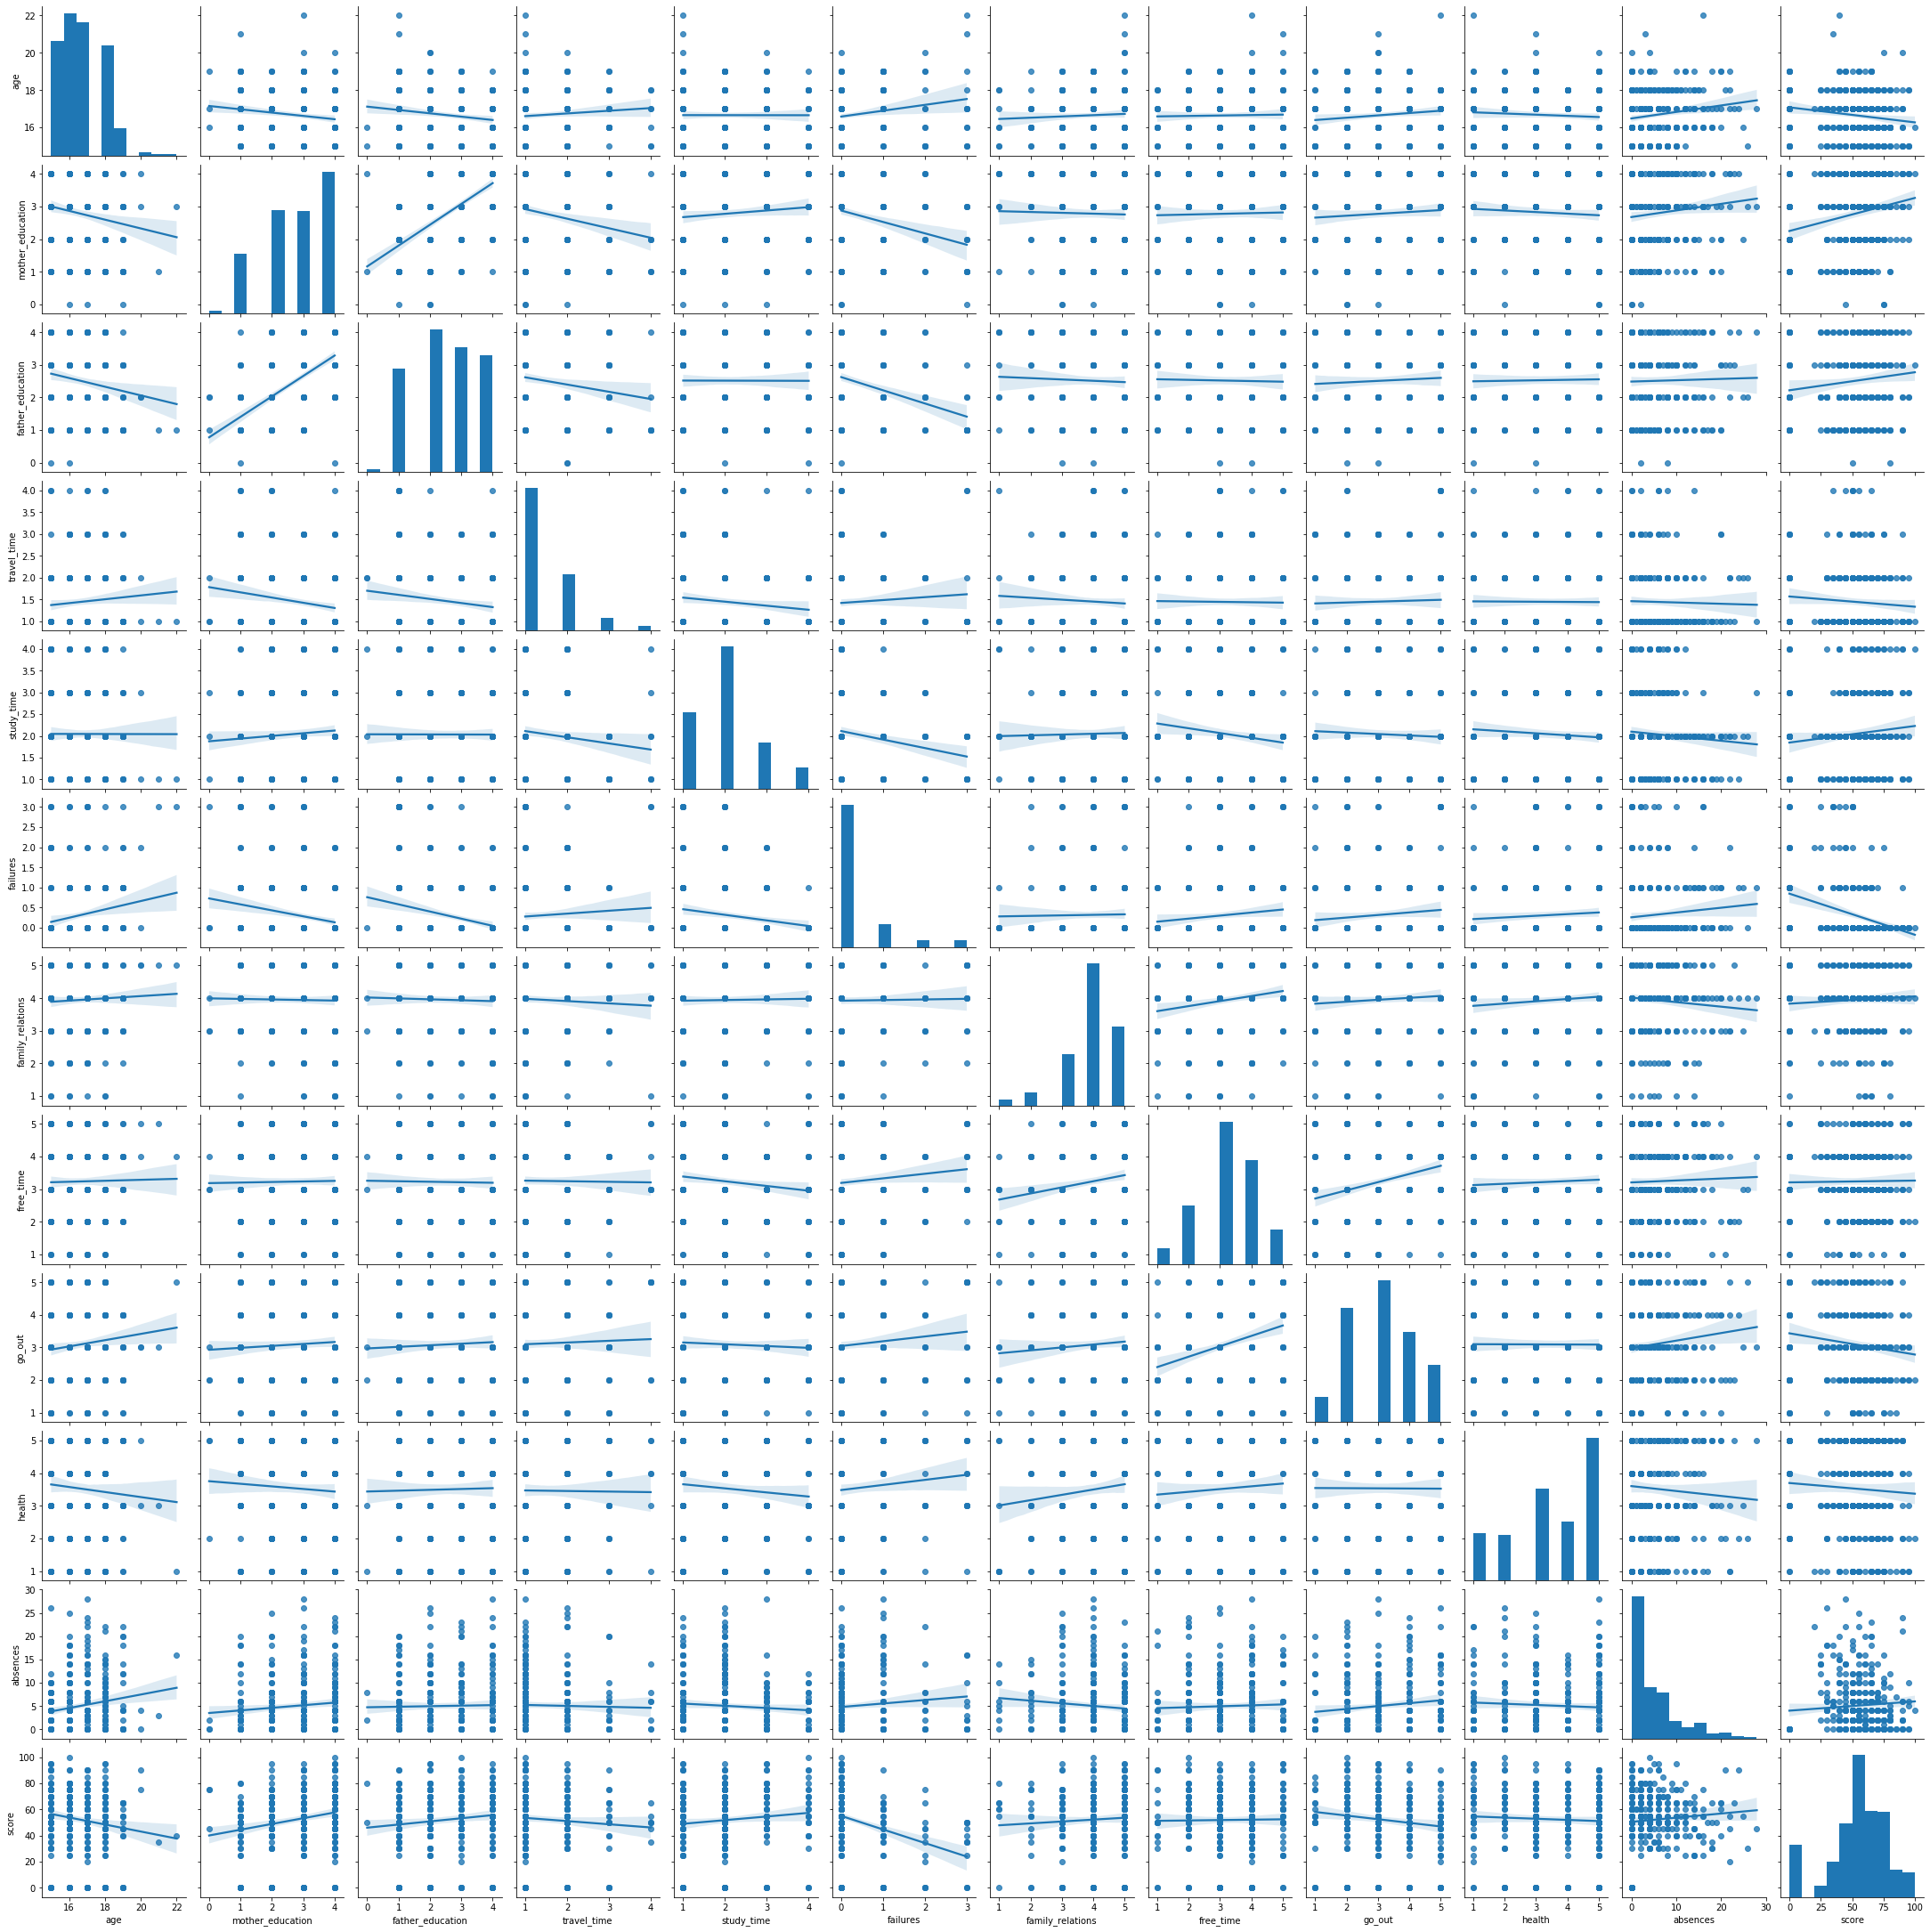

In [28]:
sns.pairplot(math, kind = 'reg')

In [29]:
math.corr()

age  mother_education  father_education  travel_time  \
age               1.000000         -0.154698         -0.154537     0.079753   
mother_education -0.154698          1.000000          0.632551    -0.187310   
father_education -0.154537          0.632551          1.000000    -0.144527   
travel_time       0.079753         -0.187310         -0.144527     1.000000   
study_time       -0.001264          0.079272         -0.002099    -0.114876   
failures          0.180409         -0.227702         -0.268244     0.069110   
family_relations  0.048636         -0.020764         -0.033915    -0.055372   
free_time         0.018927          0.019027         -0.017056    -0.012565   
go_out            0.109677          0.058561          0.047332     0.032972   
health           -0.069965         -0.062270          0.019785    -0.008499   
absences          0.158890          0.105916          0.021639    -0.024692   
score            -0.147411          0.211362          0.115315    -0.075884   

                  study_time  failures  family_relations  free_time    go_out  \
age                -0.001264  0.180409          0.048636   0.018927  0.109677   
mother_education    0.079272 -0.227702         -0.020764   0.019027  0.058561   
father_education   -0.002099 -0.268244         -0.033915  -0.017056  0.047332   
travel_time        -0.114876  0.069110         -0.055372  -0.012565  0.032972   
study_time          1.000000 -0.164983          0.018906  -0.126010 -0.042428   
failures           -0.164983  1.000000          0.015898   0.102870  0.096437   
family_relations    0.018906  0.015898          1.000000   0.170012  0.072852   
free_time          -0.126010  0.102870          0.170012   1.000000  0.282717   
go_out             -0.042428  0.096437          0.072852   0.282717  1.000000   
health             -0.076072  0.080086          0.106771   0.059165 -0.003960   
absences           -0.070613  0.094473         -0.088450   0.034421  0.120006   
score               0.103180 -0.325960          0.056825   0.012634 -0.134490   

                    health  absences     score  
age              -0.069965  0.158890 -0.147411  
mother_education -0.062270  0.105916  0.211362  
father_education  0.019785  0.021639  0.115315  
travel_time      -0.008499 -0.024692 -0.075884  
study_time       -0.076072 -0.070613  0.103180  
failures          0.080086  0.094473 -0.325960  
family_relations  0.106771 -0.088450  0.056825  
free_time         0.059165  0.034421  0.012634  
go_out           -0.003960  0.120006 -0.134490  
health            1.000000 -0.062399 -0.053952  
absences         -0.062399  1.000000  0.079500  
score            -0.053952  0.079500  1.000000